In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import json
import random
import cv2
import numpy as np

from tqdm import tqdm
from pathlib import Path
from data_setup_old import CustomDataSet
from collections import defaultdict
from models import TinyVGG
try:
    import torch
    import torchvision
    assert int(torch.__version__.split('.')[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split('.')[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version {torch.__version__}")
    print(f"torchvision version {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installinf nightly version...")
    os.system("pip3 install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cu117")
    import torch
    import torchvision
    print(f"torch version {torch.__version__}")
    print(f"torchvision version {torchvision.__version__}")

try:
    from torchinfo import summary
except:
    print(f"[INFO] Couldn't find torchinfo...\nInstalling it...")
    os.system("pip3 install -q torchinfo")
    from torchinfo import summary

from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32, 114, 114]        --
|    └─Conv2d: 2-1                       [-1, 32, 228, 228]        896
|    └─ReLU: 2-2                         [-1, 32, 228, 228]        --
|    └─MaxPool2d: 2-3                    [-1, 32, 114, 114]        --
|    └─BatchNorm2d: 2-4                  [-1, 32, 114, 114]        64
├─Sequential: 1-2                        [-1, 32, 114, 114]        --
|    └─Conv2d: 2-5                       [-1, 32, 114, 114]        9,248
|    └─BatchNorm2d: 2-6                  [-1, 32, 114, 114]        64
├─Sequential: 1-3                        [-1, 32, 57, 57]          --
|    └─Conv2d: 2-7                       [-1, 32, 114, 114]        9,248
|    └─ReLU: 2-8                         [-1, 32, 114, 114]        --
|    └─MaxPool2d: 2-9                    [-1, 32, 57, 57]          --
|    └─BatchNorm2d: 2-10                 [-1, 32, 57, 57]          64
├─Sequen

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
def Category_reader(path: str):
    with open(path, 'r') as f:
        text = json.load(f)
    categories = text['categories']
    class_names = {}
    for category in categories:
        class_names[category['id']] = [category['supercategory'], category['name']]
    return class_names

In [4]:
train_image_path = Path("/home/famousdeer/Desktop/Praca magisterska/Program/data/COCO/Images/train2017")
train_ann_path = Path("/home/famousdeer/Desktop/Praca magisterska/Program/data/COCO/annotations/instances_train2017.json")
val_image_path = Path("/home/famousdeer/Desktop/Praca magisterska/Program/data/COCO/Images/val2017")
val_ann_path = Path("/home/famousdeer/Desktop/Praca magisterska/Program/data/COCO/annotations/instances_val2017.json")

In [5]:
class_names = Category_reader(val_ann_path)
class_names

{1: ['person', 'person'],
 2: ['vehicle', 'bicycle'],
 3: ['vehicle', 'car'],
 4: ['vehicle', 'motorcycle'],
 5: ['vehicle', 'airplane'],
 6: ['vehicle', 'bus'],
 7: ['vehicle', 'train'],
 8: ['vehicle', 'truck'],
 9: ['vehicle', 'boat'],
 10: ['outdoor', 'traffic light'],
 11: ['outdoor', 'fire hydrant'],
 13: ['outdoor', 'stop sign'],
 14: ['outdoor', 'parking meter'],
 15: ['outdoor', 'bench'],
 16: ['animal', 'bird'],
 17: ['animal', 'cat'],
 18: ['animal', 'dog'],
 19: ['animal', 'horse'],
 20: ['animal', 'sheep'],
 21: ['animal', 'cow'],
 22: ['animal', 'elephant'],
 23: ['animal', 'bear'],
 24: ['animal', 'zebra'],
 25: ['animal', 'giraffe'],
 27: ['accessory', 'backpack'],
 28: ['accessory', 'umbrella'],
 31: ['accessory', 'handbag'],
 32: ['accessory', 'tie'],
 33: ['accessory', 'suitcase'],
 34: ['sports', 'frisbee'],
 35: ['sports', 'skis'],
 36: ['sports', 'snowboard'],
 37: ['sports', 'sports ball'],
 38: ['sports', 'kite'],
 39: ['sports', 'baseball bat'],
 40: ['sports',

In [6]:
# Creating image size base on tabel 3 in the ViT paper
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 4

In [7]:
# Create transform pipeline manually
manual_transform = transforms.Compose([
                                        transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                        transforms.ToTensor()
                                        ])
print(f"Manually created transforms: {manual_transform}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


In [8]:
train_coco = CustomDataSet(root=train_image_path, annFile=train_ann_path, transform=manual_transform)
val_coco = CustomDataSet(root=val_image_path, annFile=val_ann_path, transform=manual_transform)

loading annotations into memory...
Done (t=12.12s)
creating index...
index created!
loading annotations into memory...
Done (t=11.50s)
creating index...
index created!
loading annotations into memory...
Done (t=0.41s)
creating index...
index created!
loading annotations into memory...
Done (t=0.29s)
creating index...
index created!


In [9]:
def resize_bbox(path: str, image_size: int, coco):
    """Function resizing boundary box coordinates according to original and new image size.

    Args:
        path (str): Path to json file with annotations
        image_size (int): New Image size
        coco (_type_): COCO dataset
    """
    with open(path, 'r') as f:
        text = json.load(f)
    images = text['images']
    img_org_size = {}
    for image in tqdm(images):
        id = image['id']
        height = image['height']
        width = image['width']
        img_org_size[id] = [height, width]
    for anns in tqdm(range(len(coco))):
        for ann in range(len(coco[anns][1])):
            height, width = img_org_size[coco[anns][1][ann]['image_id']]
            bbox = coco[anns][1][ann]['bbox']
            bbox[0] *= image_size/width
            bbox[1] *= image_size/height
            bbox[2] *= image_size/width
            bbox[3] *= image_size/height
            coco[anns][1][ann]['bbox'] = bbox

resize_bbox(val_ann_path, IMG_SIZE, val_coco)
resize_bbox(train_ann_path, IMG_SIZE, train_coco)


100%|██████████| 118287/118287 [2:57:25<00:00, 11.11it/s]  


In [45]:
train_loader = DataLoader(
                        dataset=train_coco,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=NUM_WORKERS,
                        pin_memory=True,
                        collate_fn=lambda x: x
                        )
val_loader = DataLoader(
                        dataset=val_coco,
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        num_workers=NUM_WORKERS,
                        pin_memory=True,
                        collate_fn=lambda x: x
                        )

In [38]:
model1 = TinyVGG(input_shape=3, hidden_units=32).to(device)
model1

TinyVGG(
  (convblockv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convblockv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convblockv3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (convblockv4): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mo

In [46]:
# LOSS FUNCTIONS
idx_p =[0]
idx_bb = [1, 2, 3, 4]
idx_cls = [i for i in range(5, 95)]


def loss_bb(y_true, y_pred):
    y_true = torch.index_select(y_true, -1, torch.tensor(idx_bb))
    y_pred = torch.index_select(y_pred, -1, torch.tensor(idx_bb))

    loss_fn = nn.MSELoss()
    loss = loss_fn(y_true, y_pred, reduction='none')

    return torch.mean(loss[loss > 0.0])

def loss_p(y_true, y_pred):
    y_true = torch.index_select(y_true, idx_p, axis=-1)
    y_pred = torch.index_select(y_true, idx_p, axix=-1)

    loss_fn = nn.BCELoss()
    loss = loss_fn(y_true, y_pred)
    
    return torch.sum(loss)


def loss_cls(y_true, y_pred):
    y_true = torch.index_select(y_true, idx_cls, axis=-1)
    y_pred = torch.index_select(y_true, idx_cls, axis=-1)

    loss_fn = nn.BCELoss()
    loss = loss_fn(y_true, y_pred)

    return torch.sum(loss)


def loss_fn(y_true, y_pred):
    return loss_bb(y_true, y_pred) + loss_p(y_true, y_pred) +loss_cls(y_true, y_pred)

optimizer = torch.optim.Adam(params=model1.parameters(), lr=0.003)



In [51]:
def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
    
    # Put the model into train mode
    model.train()

    # Setup train loss and train accuray values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, X, y in enumerate(dataloader):

        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass 
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward 
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [52]:
# Create a test step
def test_step(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              device=device):
    
    model.eval()

    # Setup test loss and test acc 
    test_loss, test_acc = 0, 0

    # Turn on inference mode
    with torch.inference_mode():

        # Loop through DataLoader 
        for batch, X, y in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            y_pred = model(X)

            # 2. Calculate the loss
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            # 3. Calculate the acc
            test_pred_labels = y_pred.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))
    
    # Adjust metric to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc

In [32]:
from tqdm.auto import tqdm

def train(model: nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: nn.Module = nn.CrossEntropyLoss(),
          device=device,
          epochs: int = 5):
    
    # Create a model dict
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    
    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           optimizer=optimizer,
                                           loss_fn=loss_fn,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        
        # Print out what's happening 
        print(f"Epoch: {epoch} | Train loss: {train_loss:.5f} | Train acc: {train_acc*100:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc*100:.2f}%")

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [53]:
NUM_EPOCHS = 5

model_0_results = train(model=model1,
                        train_dataloader=train_loader,
                        test_dataloader=val_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        device=device,
                        epochs=NUM_EPOCHS)


  0%|          | 0/5 [00:00<?, ?it/s]

ValueError: not enough values to unpack (expected 3, got 2)

{'segmentation': [[376.97, 176.91, 398.81, 176.91, 396.38, 147.78, 447.35, 146.17, 448.16, 172.05, 448.16, 178.53, 464.34, 186.62, 464.34, 192.28, 448.97, 195.51, 447.35, 235.96, 441.69, 258.62, 454.63, 268.32, 462.72, 276.41, 471.62, 290.98, 456.25, 298.26, 439.26, 292.59, 431.98, 308.77, 442.49, 313.63, 436.02, 316.86, 429.55, 322.53, 419.84, 354.89, 402.04, 359.74, 401.24, 312.82, 370.49, 303.92, 391.53, 299.87, 391.53, 280.46, 385.06, 278.84, 381.01, 278.84, 359.17, 269.13, 373.73, 261.85, 374.54, 256.19, 378.58, 231.11, 383.44, 205.22, 385.87, 192.28, 373.73, 184.19]], 'area': 12190.44565, 'iscrowd': 0, 'image_id': 391895, 'bbox': [125.70949999999999, 90.95022222222222, 39.3575, 132.888], 'category_id': 4, 'id': 151091}
{'segmentation': [[352.55, 146.82, 353.61, 137.66, 356.07, 112.66, 357.13, 94.7, 357.13, 84.49, 363.12, 73.92, 370.16, 68.64, 370.16, 66.53, 368.4, 63.71, 368.05, 54.56, 361.0, 53.85, 356.07, 50.33, 356.43, 46.46, 364.17, 42.23, 369.1, 35.89, 371.22, 30.96, 376.85,

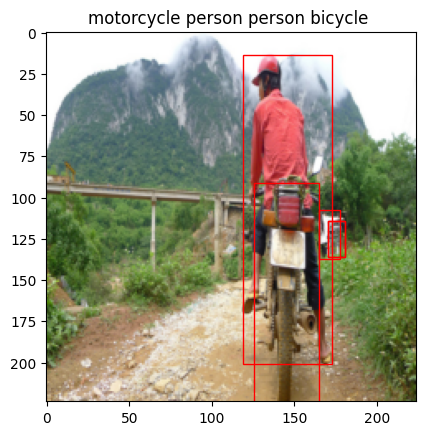

In [43]:
# VISUALIZATION IMAGE FROM DATALOADER

iter_image_batch = iter(train_loader.dataset)
image_batch = next(iter_image_batch)

image, labels = image_batch[0], image_batch[1]



title = ''
img = image.numpy().transpose(1,2,0)
img = img.copy()
plt.imshow(img)
ax = plt.gca()
for label in labels:
    title += class_names[label['category_id']][1] + ' '
    bbox = label['bbox']
    print(label)
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

ax.add_patch(rect)
# plt.imshow(image.permute(1,2,0))
plt.title(title)
plt.show()
